<a href="https://colab.research.google.com/github/rim-yu/SGU_ANT6320_Assignment/blob/master/Exercise04_head_pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [0]:
%reload_ext autoreload
%autoreload 2
# reload automatically.
%matplotlib inline
# notebook을 실행한 browser에서 바로 Rich output을 볼 수 있게 해주는 command. 

In [0]:
from fastai.vision import *
# fastai.vision의 모든 module을 import한다.

## Getting and converting the data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE) 
# url을 통해 BIWI_HEAD_POSE file의 path를 가져온다. 

In [5]:
path

PosixPath('/root/.fastai/data/biwi_head_pose')

In [38]:
cd /root/\.fastai/data/biwi_head_pose

/root/.fastai/data/biwi_head_pose


In [40]:
cd /root/\.fastai/data/biwi_head_pose
ls

01/     04/     07/     10/     13/     16/     19/     22/     io_sample.cpp
01.obj  04.obj  07.obj  10.obj  13.obj  16.obj  19.obj  22.obj  readme.txt
02/     05/     08/     11/     14/     17/     20/     23/
02.obj  05.obj  08.obj  11.obj  14.obj  17.obj  20.obj  23.obj
03/     06/     09/     12/     15/     18/     21/     24/
03.obj  06.obj  09.obj  12.obj  15.obj  18.obj  21.obj  24.obj


In [43]:
cd /root/\.fastai/data/biwi_head_pose/01
ls

depth.cal             frame_00169_rgb.jpg   frame_00336_rgb.jpg
frame_00003_pose.txt  frame_00170_pose.txt  frame_00337_pose.txt
frame_00003_rgb.jpg   frame_00170_rgb.jpg   frame_00337_rgb.jpg
frame_00004_pose.txt  frame_00171_pose.txt  frame_00338_pose.txt
frame_00004_rgb.jpg   frame_00171_rgb.jpg   frame_00338_rgb.jpg
frame_00005_pose.txt  frame_00172_pose.txt  frame_00339_pose.txt
frame_00005_rgb.jpg   frame_00172_rgb.jpg   frame_00339_rgb.jpg
frame_00006_pose.txt  frame_00173_pose.txt  frame_00340_pose.txt
frame_00006_rgb.jpg   frame_00173_rgb.jpg   frame_00340_rgb.jpg
frame_00007_pose.txt  frame_00174_pose.txt  frame_00341_pose.txt
frame_00007_rgb.jpg   frame_00174_rgb.jpg   frame_00341_rgb.jpg
frame_00008_pose.txt  frame_00175_pose.txt  frame_00342_pose.txt
frame_00008_rgb.jpg   frame_00175_rgb.jpg   frame_00342_rgb.jpg
frame_00009_pose.txt  frame_00176_pose.txt  frame_00343_pose.txt
frame_00009_rgb.jpg   frame_00176_rgb.jpg   frame_00343_rgb.jpg
frame_00010_pose.txt  frame_00177

In [4]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal 
# np.genfromtxt() : Load data from a text file, with missing values handled as specified.
# skip_footer : The number of lines to skip at the end of the file. 
# np.genfromtxt function : https://kongdols-room.tistory.com/57
# rgb.cal : rgb calculator.?
# /root/\.fastai/data/biwi_head_pose/01 path에 rgb.cal file이 있었음. 
# skip_footer가 무엇이고 왜 6인가.

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg' 
# file name을 위와 같이 저장한다. 

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'
# img2txt_name() 함수를 생성한다.
# path/f = /root/.fastai/data/biwi_head_pose/09/frame_00667_rgb.jpg
# 09/frame_00667_rgb.jpg -> 09/frame_00376_pose.txt 가 됨. 
# img2txt_name function은 결국 jpg file name을 넣으면 txt file name을 return하는 듯.
# [:-7]은 09/frame_00667_rgb.jpg -> 09/frame_00667_ 

In [53]:
temp_str = "abcdefghijk"
temp_str[:-1]
# 뒤에서 - 방향으로, 숫자만큼 날리는 듯함. 

'abcdefghij'

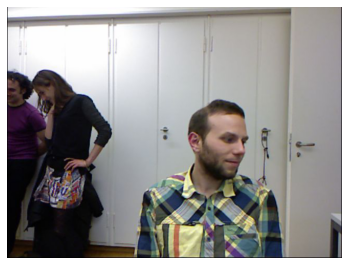

In [31]:
img = open_image(path/fname)
img.show(figsize=(6, 6))
# /root/.fastai/data/biwi_head_pose/09/frame_00667_rgb.jpg를 img에 저장해서 보여줌. 

In [27]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr
# img2txt_name(fname)인 경우 fname_pose.txt를 return함.
# skip_header는 뭐임.
# fnames_pose.txt에는 왜 원소 3개 array가 있는 걸까..

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords): # coords = array([187.332 ,  40.3892, 893.135 ])
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2] # = 187.332 * 517.679/893.135 + 320 
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1]) # 어떤 수학적 의의가 있는지 모르겠음. 어찌됐든 원소 2개 array 생김. 
# coords는 coordinates 약자 같음.?

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3) # array([187.332 ,  40.3892, 893.135 ])
    return convert_biwi(ctr) 

def get_ip(img, pts): return ImagePoints(FlowField(img.size, pts), scale=True)

# ImagePoints : Create an ImagePoints object from a flow of coordinates.
# Flowfield : the raw points are gathered in a FlowField object, 
# which is a class that wraps together a bunch of coordinates with the corresponding image size. 
# In fastai, we expect points to have the y coordinate first by default. 
# The underlying data of pnts is the flow of points scaled from -1 to 1 (again with the y coordinate first).
# get_ip(img, ctr)로 사용. pts = ctr.?

"""
array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])
"""

In [29]:
get_ctr(fname)

tensor([263.9104, 428.5814])

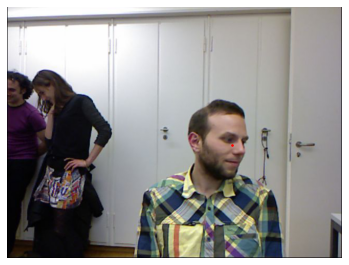

In [30]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))
# we expect points to have the y coordinate first by default. 

## Creating a dataset

In [0]:
data = (PointsItemList.from_folder(path) # ItemList for points.
        .split_by_valid_func(lambda o: o.parent.name=='13') # lambda : 함수 이름이 없는 한줄짜리 함수.
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

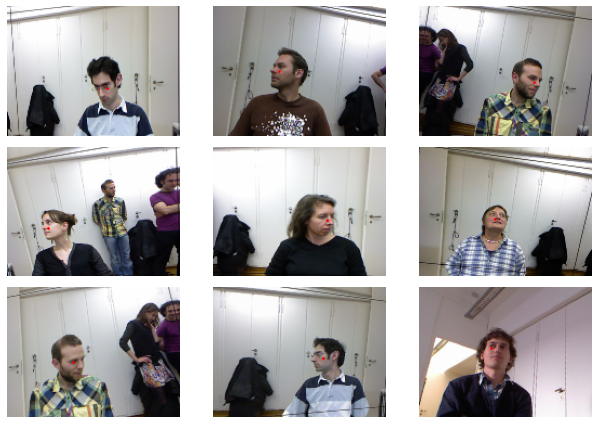

In [55]:
data.show_batch(3, figsize=(9,6))

## Train model

In [56]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


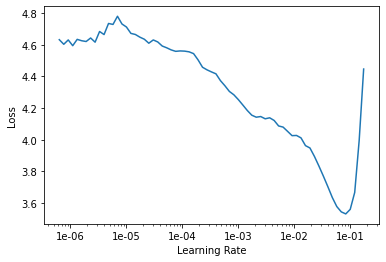

In [57]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2
# 2e-2 = 0.02

In [59]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.133245,0.011921,03:12
1,0.045138,0.002957,03:08
2,0.015420,0.006661,03:04
3,0.008567,0.002736,03:01
4,0.006796,0.001616,02:58


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

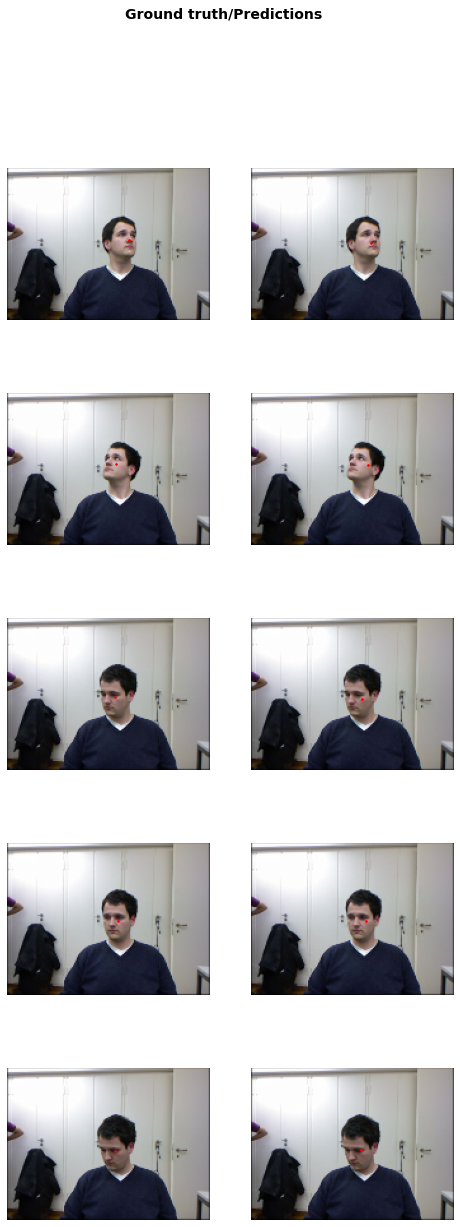

In [62]:
learn.show_results()

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

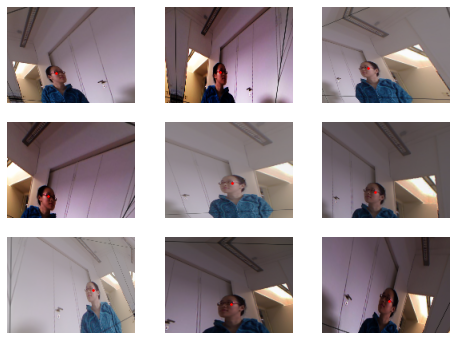

In [64]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))